# 📓 Berry Survival Analysis

#### Edibility and Species Classification


### Business Understanding

The primary goal is to create reliable methods for identifying edible berries to survive. This involves three sub-tasks:

- Deriving clear rules for edibility based on plant characteristics.
- Classifying plants into the five species identified by a previous expedition.
- Developing a strategy to determine edibility when only partial information (just leaves, berries, or petals) is available.


### Data Understanding



In [2]:
# Import Libraries

import sys
sys.path.append("..") # Adds higher directory to python modules path.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load the `edible.json` dataset and examine its structure

In [8]:
# Load the datasets from your JSON files

try:
    df_edible = pd.read_json('../data/edible.json')
    df_species = pd.read_json('../data/species.json')
    df_leaf = pd.read_json('../data/leaf.json')
    df_berry = pd.read_json('../data/berry.json')
    df_petal = pd.read_json('../data/petal.json')

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure edible.json, species.json, leaf.json, berry.json, and petal.json are in the same directory.")
    raise

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Display basic information about the datasets
print("First 5 rows of the edible dataset:")
print(df_edible.head())

print("\nDataset information:")
df_edible.info()

print("\nValue counts for each column:")
print(df_edible["leaf_shape"].value_counts())
print(df_edible["petal_colour"].value_counts())
print(df_edible["berry_colour"].value_counts())
print(df_edible["edible"].value_counts())

First 5 rows of the edible dataset:
   leaf_shape petal_colour berry_colour  edible
0       ovate         pink         blue   False
1  lanceolate        white         blue    True
2  lanceolate        white         blue    True
3       ovate        white       purple   False
4       ovate        white       purple   False

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   leaf_shape    500 non-null    object
 1   petal_colour  500 non-null    object
 2   berry_colour  500 non-null    object
 3   edible        500 non-null    bool  
dtypes: bool(1), object(3)
memory usage: 12.3+ KB

Value counts for each column:
leaf_shape
ovate         300
lanceolate    200
Name: count, dtype: int64
petal_colour
white    305
pink     195
Name: count, dtype: int64
berry_colour
blue      151
purple    134
green      82
grey       71
none      

### 2.1 Can you identify the rules by which you can determine whether a plant is edible?

To find clear, interpretable rules, we'll use a Decision Tree Classifier. This model naturally creates a flowchart of decisions that is easy to understand and apply in the field.

### Data Preparation

The features (leaf_shape, petal_colour, berry_colour) are categorical and need to be converted into a numerical format for our model. We'll use one-hot encoding.

In [ ]:
# Edibility Analysis

# Define features (X) and target (y)
X = df_edible.drop('edible', axis=1)
y = df_edible["edible"]

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Create a DataFrame with encoded features
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(X.columns))

print("\nFirst 5 rows of the encoded features:")
print(X_encoded_df.head())
print("\nShape of encoded features:", X_encoded_df.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y, test_size=0.3, random_state=42)

print("\nShape of training data (X_train, y_train):", X_train.shape, y_train.shape)
print("Shape of testing data (X_test, y_test):", X_test.shape, y_test.shape)


First 5 rows of the encoded features:
   leaf_shape_lanceolate  leaf_shape_ovate  petal_colour_pink  \
0                    0.0               1.0                1.0   
1                    1.0               0.0                0.0   
2                    1.0               0.0                0.0   
3                    0.0               1.0                0.0   
4                    0.0               1.0                0.0   

   petal_colour_white  berry_colour_blue  berry_colour_green  \
0                 0.0                1.0                 0.0   
1                 1.0                1.0                 0.0   
2                 1.0                1.0                 0.0   
3                 1.0                0.0                 0.0   
4                 1.0                0.0                 0.0   

   berry_colour_grey  berry_colour_none  berry_colour_purple  
0                0.0                0.0                  0.0  
1                0.0                0.0                  0.

### Modeling & Evaluation


Accuracy of Decision Tree Classifier: 0.98

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98        95
        True       0.98      0.96      0.97        55

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



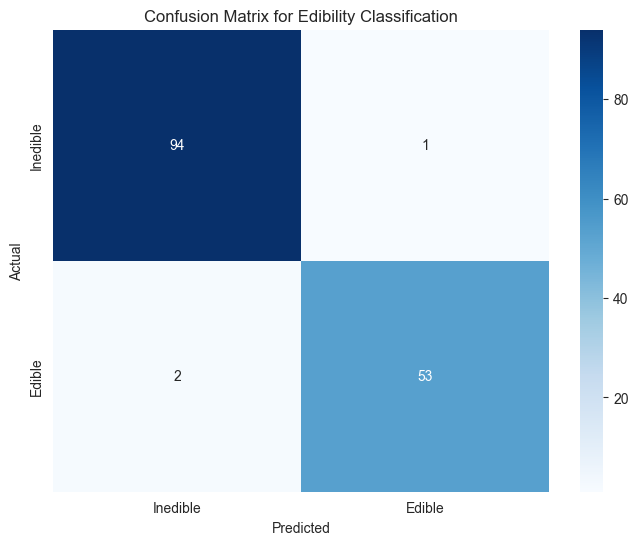

In [10]:
# Initialize and train the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=3)

# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

#Evaluate the model's accuracy on unseen data

print("\nAccuracy of Decision Tree Classifier:", accuracy_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Inedible", "Edible"], yticklabels=["Inedible", "Edible"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Edibility Classification")
plt.savefig("edibility_confusion_matrix.png")
plt.show()


Edibility Model Accuracy: 0.8480

Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.93      0.90        88
        True       0.80      0.65      0.72        37

    accuracy                           0.85       125
   macro avg       0.83      0.79      0.81       125
weighted avg       0.84      0.85      0.84       125



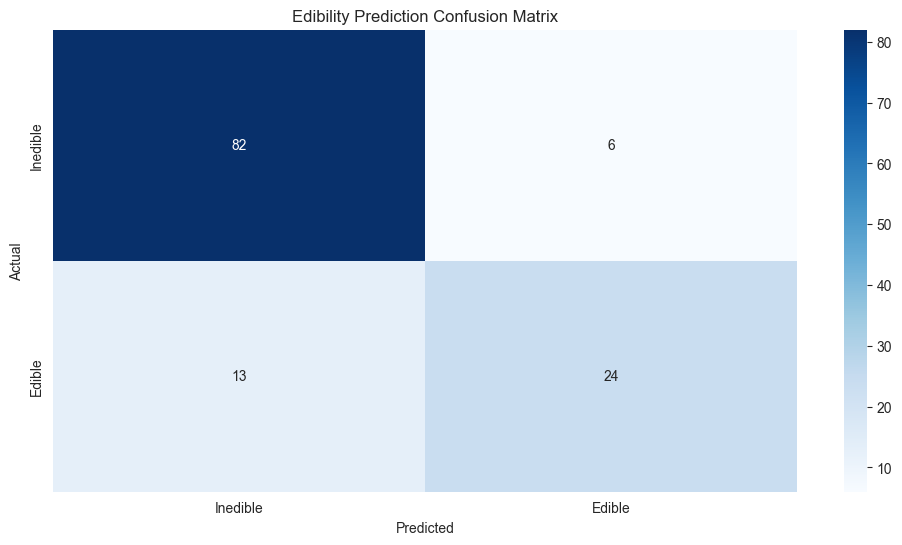

In [11]:
# Split data into training and testing sets
X_train_ed, X_test_ed, y_train_ed, y_test_ed = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Create a preprocessing pipeline for one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), X.columns)
    ],
    remainder='passthrough'
)

# Create the full pipeline with the Decision Tree Classifier
edibility_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=3)) # Limit depth for interpretability
])

# Train the model
edibility_pipeline.fit(X_train_ed, y_train_ed)

# Make predictions
y_pred_ed = edibility_pipeline.predict(X_test_ed)

# Evaluate the model
accuracy_ed = accuracy_score(y_test_ed, y_pred_ed)
print(f"Edibility Model Accuracy: {accuracy_ed:.4f}\n")
print("Classification Report:")
print(classification_report(y_test_ed, y_pred_ed))

# Confusion Matrix
cm = confusion_matrix(y_test_ed, y_pred_ed)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inedible', 'Edible'], yticklabels=['Inedible', 'Edible'])
plt.title('Edibility Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Rule Identification

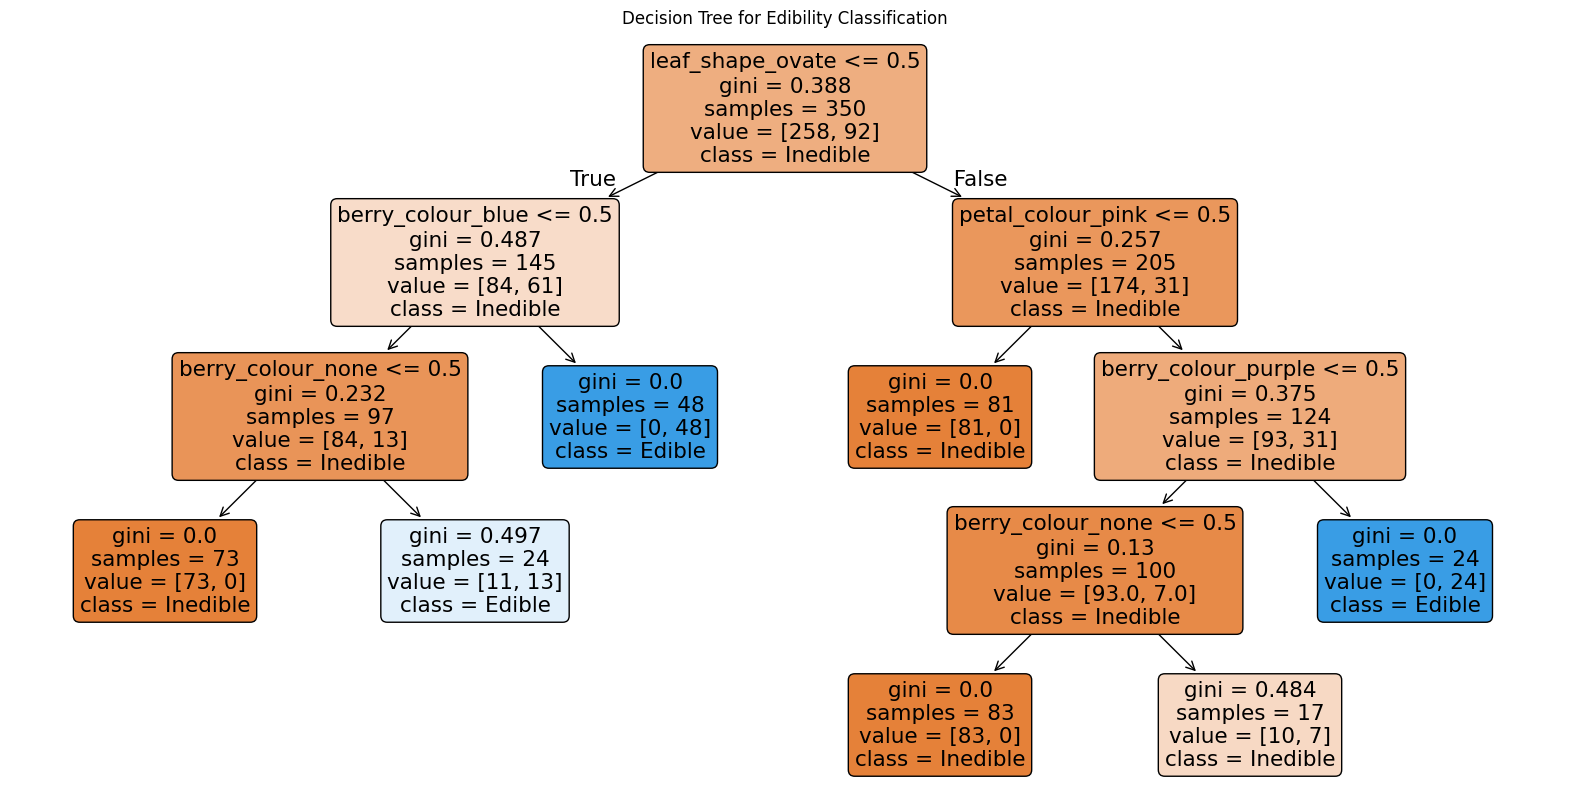

In [8]:
# Visualize the Decision Tree to extract rules
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, feature_names=X_encoded_df.columns, class_names=["Inedible", "Edible"], filled=True, rounded=True)
plt.title("Decision Tree for Edibility Classification")
plt.savefig("edibility_decision_tree.png")
plt.show()

Extract rules (simplified for display)
This part would typically involve parsing the tree structure, but for a notebook, the visualization is key.
A simplified representation of rules can be inferred from the plot.
For example, if petal_colour_pink <= 0.5 (meaning petal_colour is not pink) and berry_colour_blue <= 0.5 (meaning berry_colour is not blue), then it might be inedible.
If petal_colour_pink > 0.5 (meaning petal_colour is pink) and berry_colour_purple > 0.5 (meaning berry_colour is purple), then it might be edible.

### 2.2 Species Identification

We'll use a similar approach as before, but this time our target is the species column.

#### Data Understanding

In [13]:
print("\nDataset information:")
df_species.info()

print("\nFirst 5 rows of the species dataset:")
print(df_species.head())


print("\nValue counts for each column:")
print(df_species["leaf_shape"].value_counts())
print(df_species["petal_colour"].value_counts())
print(df_species["berry_colour"].value_counts())
print(df_species["species"].value_counts())



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   leaf_shape    500 non-null    object
 1   petal_colour  500 non-null    object
 2   berry_colour  500 non-null    object
 3   species       500 non-null    object
dtypes: object(4)
memory usage: 15.8+ KB

First 5 rows of the species dataset:
   leaf_shape petal_colour berry_colour              species
0       ovate         pink         blue  berrius delphinorum
1  lanceolate        white         blue       berrius actius
2  lanceolate        white         blue       berrius actius
3       ovate        white       purple       berrius codiae
4       ovate        white       purple       berrius codiae

Value counts for each column:
leaf_shape
ovate         300
lanceolate    200
Name: count, dtype: int64
petal_colour
white    305
pink     195
Name: count, dtype: int64
berry_co

### Data Preparation

Similar to the edibility classification, we will one-hot encode the categorical features for the species dataset.

In [ ]:
X_species = df_species.drop('species', axis=1)
y_species = df_species["species"]

# Encode the target labels (species names)
label_encoder = LabelEncoder()
y_species_encoded = label_encoder.fit_transform(y_species)

# Split the data into training and testing sets
X_train_species, X_test_species, y_train_species, y_test_species = train_test_split(y_species_encoded, y_species, test_size=0.3, random_state=42)

# One-hot encode categorical features
encoder_species = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_species_encoded = encoder_species.fit_transform(X_species)

# Create a DataFrame with encoded features
X_species_encoded_df = pd.DataFrame(X_species_encoded, columns=encoder_species.get_feature_names_out(X_species.columns))

### Modeling

We will use a Decision Tree Classifier to distinguish between the species.

In [11]:
dt_classifier_species = DecisionTreeClassifier(random_state=42)
dt_classifier_species.fit(X_train_species, y_train_species)

# Make predictions on the test set
y_pred_species = dt_classifier_species.predict(X_test_species)

#### Evaluation


Accuracy of Decision Tree Classifier for Species: 0.9066666666666666

Classification Report for Species:
                     precision    recall  f1-score   support

     berrius actius       0.84      1.00      0.92        27
   berrius boethiae       0.82      0.94      0.88        35
     berrius codiae       1.00      1.00      1.00        24
berrius delphinorum       0.94      0.81      0.87        36
    berrius elephas       1.00      0.82      0.90        28

           accuracy                           0.91       150
          macro avg       0.92      0.91      0.91       150
       weighted avg       0.92      0.91      0.91       150



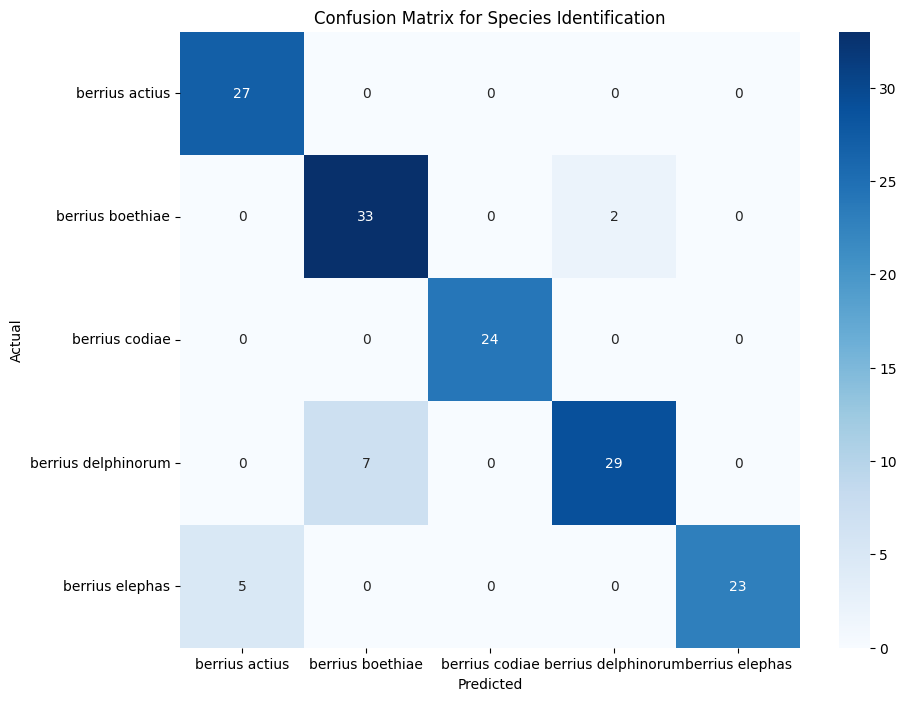

In [12]:


print("\nAccuracy of Decision Tree Classifier for Species:", accuracy_score(y_test_species, y_pred_species))
print("\nClassification Report for Species:")
print(classification_report(y_test_species, y_pred_species))

# Confusion Matrix
cm_species = confusion_matrix(y_test_species, y_pred_species)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_species, annot=True, fmt='d', cmap='Blues', xticklabels=dt_classifier_species.classes_, yticklabels=dt_classifier_species.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Species Identification")
plt.savefig("species_confusion_matrix.png")
plt.show()

#### Rule Identification

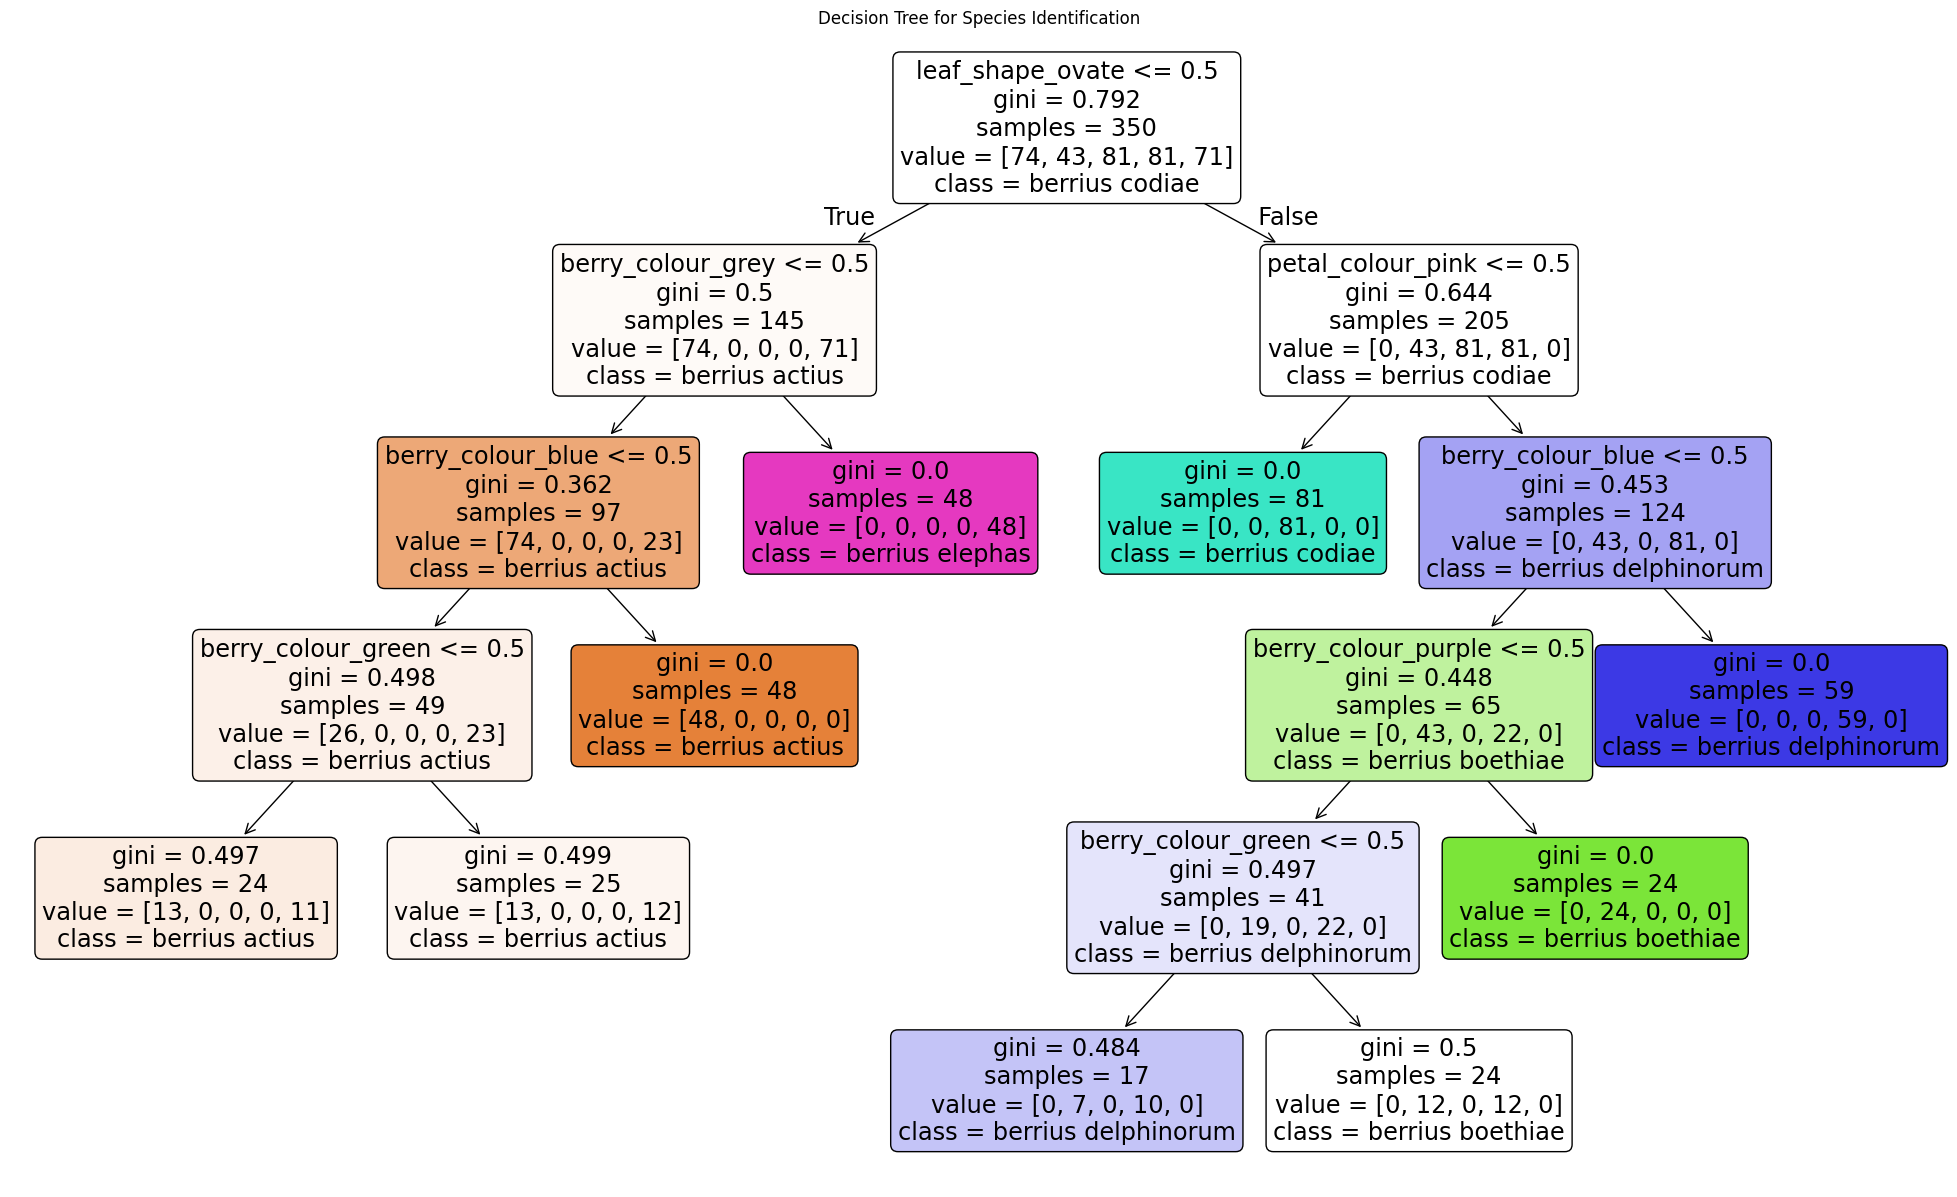

In [13]:
# Visualize the Decision Tree to extract rules
plt.figure(figsize=(25, 15))
plot_tree(dt_classifier_species, feature_names=X_species_encoded_df.columns, class_names=dt_classifier_species.classes_, filled=True, rounded=True)
plt.title("Decision Tree for Species Identification")
plt.savefig("species_decision_tree.png")
plt.show()

### 2.3 Single-Feature Classification Analysis

#### Business Understanding

In this section, we will investigate how well we can determine edibility or species using only a single characteristic (leaf shape, petal color, or berry color). This is crucial because bushes rarely have all three features present at once. We will compare two approaches:
1. Directly predicting edibility from a single feature.
2. Predicting species from a single feature, and then inferring edibility based on the species.


#### Data Understanding and Preparation

Let's prepare the `berry.json`, `leaf.json`, and `petal.json` datasets for analysis.

In [14]:

print("\nFirst 5 rows of the berry dataset:")
print(df_berry.head())

print("\nFirst 5 rows of the leaf dataset:")
print(df_leaf.head())

print("\nFirst 5 rows of the petal dataset:")
print(df_petal.head())



First 5 rows of the berry dataset:
        age      height  soil_quality berry_colour  berry_size  edible  \
0  9.795552  397.119296      3.362384         blue    8.734281   False   
1  8.596144  299.475406      5.948337         blue   10.270547    True   
2  9.446874  192.531378      4.888970         blue    7.777643    True   
3  7.342407  127.481779      3.221025       purple    8.435157   False   
4  8.103198  154.036470      3.199550       purple    8.351162   False   

               species  
0  berrius delphinorum  
1       berrius actius  
2       berrius actius  
3       berrius codiae  
4       berrius codiae  

First 5 rows of the leaf dataset:
        age      height  soil_quality  leaf_shape  leaf_size  edible  \
0  9.795552  397.119296      3.362384       ovate  16.083941   False   
1  8.596144  299.475406      5.948337  lanceolate  17.515386    True   
2  9.446874  192.531378      4.888970  lanceolate  15.677807    True   
3  7.342407  127.481779      3.221025       ov

Merge with edible and species dataframes to get target variables
For edibility, we need to know which berry_colour, leaf_shape, petal_colour corresponds to edible/inedible
For species, we need to know which berry_colour, leaf_shape, petal_colour corresponds to which species

In [15]:
# Create mappings from the full edible and species dataframes
edibility_map = df_edible.set_index(["leaf_shape", "petal_colour", "berry_colour"])["edible"].to_dict()
species_map = df_species.set_index(["leaf_shape", "petal_colour", "berry_colour"])["species"].to_dict()

In [16]:
# Function to get edibility and species based on available features
def get_edibility_and_species(row, feature_type):
    if feature_type == "berry":
        # Find a matching row in edible_df and df_species based on berry_colour
        # This is a simplification. In a real scenario, we might need to consider other features if available.
        # For this exercise, we assume the provided single feature is enough to find a match.
        matching_edible = df_edible[df_edible["berry_colour"] == row["berry_colour"]]
        matching_species = df_species[df_species["berry_colour"] == row["berry_colour"]]
        
        if not matching_edible.empty:
            # Take the most frequent edibility for that berry_colour, or a specific rule if one exists
            edible_val = matching_edible["edible"].mode()[0]
        else:
            edible_val = None

        if not matching_species.empty:
            species_val = matching_species["species"].mode()[0]
        else:
            species_val = None

        return edible_val, species_val

    elif feature_type == "leaf":
        matching_edible = df_edible[df_edible["leaf_shape"] == row["leaf_shape"]]
        matching_species = df_species[df_species["leaf_shape"] == row["leaf_shape"]]
        
        if not matching_edible.empty:
            edible_val = matching_edible["edible"].mode()[0]
        else:
            edible_val = None

        if not matching_species.empty:
            species_val = matching_species["species"].mode()[0]
        else:
            species_val = None
        return edible_val, species_val

    elif feature_type == "petal":
        matching_edible = df_edible[df_edible["petal_colour"] == row["petal_colour"]]
        matching_species = df_species[df_species["petal_colour"] == row["petal_colour"]]
        
        if not matching_edible.empty:
            edible_val = matching_edible["edible"].mode()[0]
        else:
            edible_val = None

        if not matching_species.empty:
            species_val = matching_species["species"].mode()[0]
        else:
            species_val = None
        return edible_val, species_val
    return None, None

In [17]:
# Apply the function to create new columns for edibility and species in each dataframe
df_berry[["edible", "species"]] = df_berry.apply(lambda row: get_edibility_and_species(row, "berry"), axis=1, result_type="expand")
df_leaf[["edible", "species"]] = df_leaf.apply(lambda row: get_edibility_and_species(row, "leaf"), axis=1, result_type="expand")
df_petal[["edible", "species"]] = df_petal.apply(lambda row: get_edibility_and_species(row, "petal"), axis=1, result_type="expand")

print("\nBerry dataset with edibility and species:")
print(df_berry.head())
print("\nLeaf dataset with edibility and species:")
print(df_leaf.head())
print("\nPetal dataset with edibility and species:")
print(df_petal.head())


Berry dataset with edibility and species:
        age      height  soil_quality berry_colour  berry_size  edible  \
0  9.795552  397.119296      3.362384         blue    8.734281   False   
1  8.596144  299.475406      5.948337         blue   10.270547   False   
2  9.446874  192.531378      4.888970         blue    7.777643   False   
3  7.342407  127.481779      3.221025       purple    8.435157   False   
4  8.103198  154.036470      3.199550       purple    8.351162   False   

               species  
0  berrius delphinorum  
1  berrius delphinorum  
2  berrius delphinorum  
3       berrius codiae  
4       berrius codiae  

Leaf dataset with edibility and species:
        age      height  soil_quality  leaf_shape  leaf_size  edible  \
0  9.795552  397.119296      3.362384       ovate  16.083941   False   
1  8.596144  299.475406      5.948337  lanceolate  17.515386   False   
2  9.446874  192.531378      4.888970  lanceolate  15.677807   False   
3  7.342407  127.481779      3.2

In [18]:
# Drop rows with None values (where no clear edibility/species could be inferred from single feature)
df_berry.dropna(inplace=True)
df_leaf.dropna(inplace=True)
df_petal.dropna(inplace=True)

print("\nShape of df_berry after dropping NaNs:", df_berry.shape)
print("Shape of df_leaf after dropping NaNs:", df_leaf.shape)
print("Shape of df_petal after dropping NaNs:", df_petal.shape)


Shape of df_berry after dropping NaNs: (500, 7)
Shape of df_leaf after dropping NaNs: (500, 7)
Shape of df_petal after dropping NaNs: (500, 7)


In [19]:
# One-hot encode features for single-feature classification
# Berry data
X_berry = df_berry[["berry_colour"]]
y_berry_edible = df_berry["edible"]
y_berry_species = df_berry["species"]

encoder_berry = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_berry_encoded = encoder_berry.fit_transform(X_berry)
X_berry_encoded_df = pd.DataFrame(X_berry_encoded, columns=encoder_berry.get_feature_names_out(X_berry.columns))

# Leaf data
X_leaf = df_leaf[["leaf_shape"]]
y_leaf_edible = df_leaf["edible"]
y_leaf_species = df_leaf["species"]

encoder_leaf = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_leaf_encoded = encoder_leaf.fit_transform(X_leaf)
X_leaf_encoded_df = pd.DataFrame(X_leaf_encoded, columns=encoder_leaf.get_feature_names_out(X_leaf.columns))

# Petal data
X_petal = df_petal[["petal_colour"]]
y_petal_edible = df_petal["edible"]
y_petal_species = df_petal["species"]

encoder_petal = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_petal_encoded = encoder_petal.fit_transform(X_petal)
X_petal_encoded_df = pd.DataFrame(X_petal_encoded, columns=encoder_petal.get_feature_names_out(X_petal.columns))

print("\nShape of encoded berry features:", X_berry_encoded_df.shape)
print("Shape of encoded leaf features:", X_leaf_encoded_df.shape)
print("Shape of encoded petal features:", X_petal_encoded_df.shape)


Shape of encoded berry features: (500, 5)
Shape of encoded leaf features: (500, 2)
Shape of encoded petal features: (500, 2)


In [20]:
# Split data for each single-feature dataset
X_train_berry, X_test_berry, y_train_berry_edible, y_test_berry_edible, y_train_berry_species, y_test_berry_species = train_test_split(X_berry_encoded_df, y_berry_edible, y_berry_species, test_size=0.3, random_state=42)
X_train_leaf, X_test_leaf, y_train_leaf_edible, y_test_leaf_edible, y_train_leaf_species, y_test_leaf_species = train_test_split(X_leaf_encoded_df, y_leaf_edible, y_leaf_species, test_size=0.3, random_state=42)
X_train_petal, X_test_petal, y_train_petal_edible, y_test_petal_edible, y_train_petal_species, y_test_petal_species = train_test_split(X_petal_encoded_df, y_petal_edible, y_petal_species, test_size=0.3, random_state=42)

#### Modeling and Evaluation for Single-Feature Classification

##### Approach 1: Direct Edibility Prediction

In [21]:
# Berry Color
dt_berry_edible = DecisionTreeClassifier(random_state=42)
dt_berry_edible.fit(X_train_berry, y_train_berry_edible)
y_pred_berry_edible = dt_berry_edible.predict(X_test_berry)
print("\n--- Berry Color (Direct Edibility) ---")
print("Accuracy:", accuracy_score(y_test_berry_edible, y_pred_berry_edible))
print(classification_report(y_test_berry_edible, y_pred_berry_edible))

# Leaf Shape
dt_leaf_edible = DecisionTreeClassifier(random_state=42)
dt_leaf_edible.fit(X_train_leaf, y_train_leaf_edible)
y_pred_leaf_edible = dt_leaf_edible.predict(X_test_leaf)
print("\n--- Leaf Shape (Direct Edibility) ---")
print("Accuracy:", accuracy_score(y_test_leaf_edible, y_pred_leaf_edible))
print(classification_report(y_test_leaf_edible, y_pred_leaf_edible))

# Petal Color
dt_petal_edible = DecisionTreeClassifier(random_state=42)
dt_petal_edible.fit(X_train_petal, y_train_petal_edible)
y_pred_petal_edible = dt_petal_edible.predict(X_test_petal)
print("\n--- Petal Color (Direct Edibility) ---")
print("Accuracy:", accuracy_score(y_test_petal_edible, y_pred_petal_edible))
print(classification_report(y_test_petal_edible, y_pred_petal_edible))


--- Berry Color (Direct Edibility) ---
Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       150

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150


--- Leaf Shape (Direct Edibility) ---
Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       150

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150


--- Petal Color (Direct Edibility) ---
Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       150

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



##### Approach 2: Species Prediction then Edibility Inference

First, let's create a mapping from species to edibility from the full `edible_df` and `df_species`.
We need to ensure that each species has a consistent edibility status.


In [ ]:
species_edibility_mapping = {}
for index, row in df_species.iterrows():
    leaf = row["leaf_shape"]
    petal = row["petal_colour"]
    berry = row["berry_colour"]
    species = row["species"]
    
    # Find the corresponding edibility from edible_df
    edible_status = df_edible[(df_edible["leaf_shape"] == leaf) &
                              (df_edible["petal_colour"] == petal) &
                              (df_edible["berry_colour"] == berry)]["edible"]
    
    if not edible_status.empty:
        species_edibility_mapping[species] = edible_status.iloc[0]

print("\nSpecies to Edibility Mapping:", species_edibility_mapping)

# Berry Color (Species Prediction then Edibility Inference)
dt_berry_species_indirect = DecisionTreeClassifier(random_state=42)
dt_berry_species_indirect.fit(X_train_berry, y_train_berry_species)
y_pred_berry_species_indirect = dt_berry_species_indirect.predict(X_test_berry)

y_pred_berry_edible_indirect = [species_edibility_mapping.get(s) for s in y_pred_berry_species_indirect]

print("\n--- Berry Color (Species then Edibility) ---")
print("Accuracy:", accuracy_score(y_test_berry_edible, y_pred_berry_edible_indirect))
print(classification_report(y_test_berry_edible, y_pred_berry_edible_indirect))

# Leaf Shape (Species Prediction then Edibility Inference)
dt_leaf_species_indirect = DecisionTreeClassifier(random_state=42)
dt_leaf_species_indirect.fit(X_train_leaf, y_train_leaf_species)
y_pred_leaf_species_indirect = dt_leaf_species_indirect.predict(X_test_leaf)

y_pred_leaf_edible_indirect = [species_edibility_mapping.get(s) for s in y_pred_leaf_species_indirect]

print("\n--- Leaf Shape (Species then Edibility) ---")
print("Accuracy:", accuracy_score(y_test_leaf_edible, y_pred_leaf_edible_indirect))
print(classification_report(y_test_leaf_edible, y_pred_leaf_edible_indirect))

# Petal Color (Species Prediction then Edibility Inference)
dt_petal_species_indirect = DecisionTreeClassifier(random_state=42)
dt_petal_species_indirect.fit(X_train_petal, y_train_petal_species)
y_pred_petal_species_indirect = dt_petal_species_indirect.predict(X_test_petal)

y_pred_petal_edible_indirect = [species_edibility_mapping.get(s) for s in y_pred_petal_species_indirect]

print("\n--- Petal Color (Species then Edibility) ---")
print("Accuracy:", accuracy_score(y_test_petal_edible, y_pred_petal_edible_indirect))
print(classification_report(y_test_petal_edible, y_pred_petal_edible_indirect))



Species to Edibility Mapping: {'berrius delphinorum': np.False_, 'berrius actius': np.True_, 'berrius codiae': np.False_, 'berrius boethiae': np.True_, 'berrius elephas': np.False_}

--- Berry Color (Species then Edibility) ---
Accuracy: 0.8866666666666667
              precision    recall  f1-score   support

       False       1.00      0.89      0.94       150
        True       0.00      0.00      0.00         0

    accuracy                           0.89       150
   macro avg       0.50      0.44      0.47       150
weighted avg       1.00      0.89      0.94       150


--- Leaf Shape (Species then Edibility) ---
Accuracy: 0.6333333333333333
              precision    recall  f1-score   support

       False       1.00      0.63      0.78       150
        True       0.00      0.00      0.00         0

    accuracy                           0.63       150
   macro avg       0.50      0.32      0.39       150
weighted avg       1.00      0.63      0.78       150


--- Petal Col

/Users/3n61n33r/.virtualenvs/ML-Analytics-UA7PMF5O/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/3n61n33r/.virtualenvs/ML-Analytics-UA7PMF5O/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/3n61n33r/.virtualenvs/ML-Analytics-UA7PMF5O/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag